In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import multiprocessing

In [2]:
# read dataset
df = pd.read_csv("./creditcard.csv")

In [3]:
# get data dimensions
df.shape

(284807, 31)

In [4]:
# get the data types
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

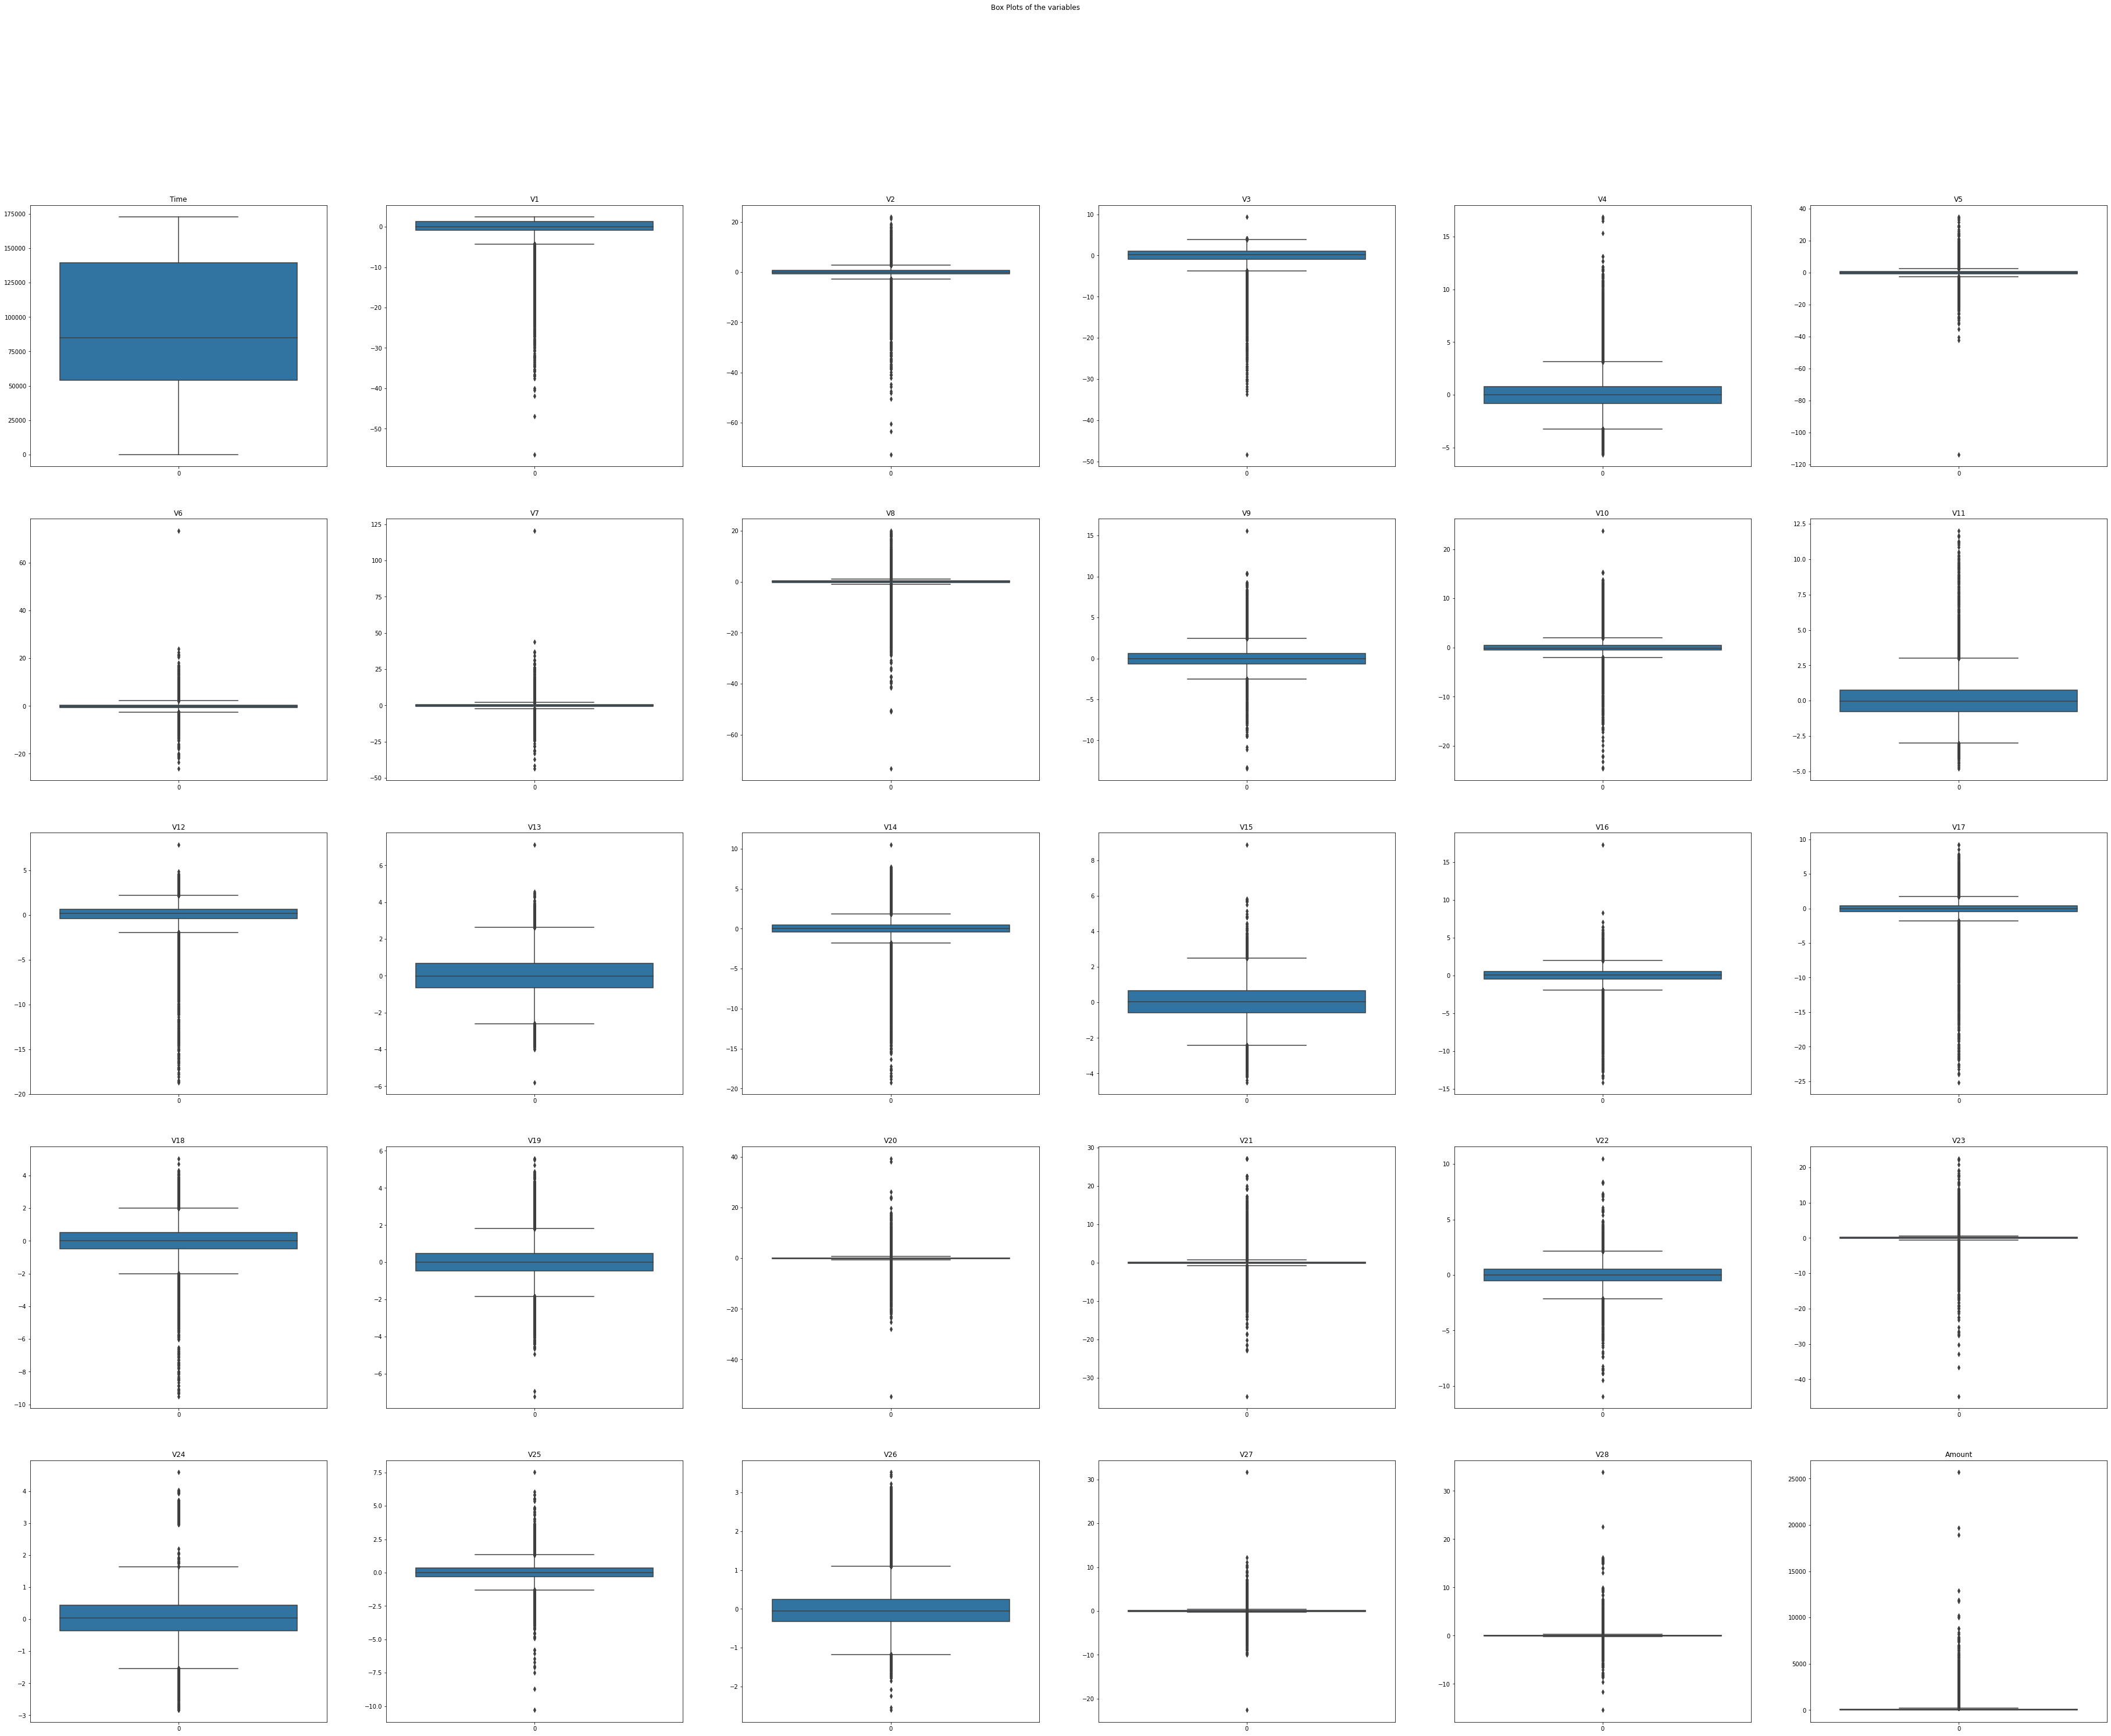

In [5]:
fig, axes = plt.subplots(5, 6, figsize=(64,48))
fig.suptitle('Box Plots of the variables')

np_df = df.to_numpy()
counter = 0
for i in range(5):
    for j in range(6):
        sns.boxplot(ax=axes[i, j], data=df.iloc[:, counter])
        axes[i, j].set_title(list(df.columns)[counter])
        counter += 1

In [6]:
# find the class distribution
target = df.to_numpy(dtype=np.int32)[:, -1]
# get the number of classes and the count for each class
classes, counts = np.unique(target, return_counts=True)

# identify the data percentage
for i in range(len(classes)):
    print("Class=%d, Count=%d, Percentage=%.3f%%" % (classes[i], counts[i], counts[i]*100/np.sum(counts)))

print("Class Imbalance:: {}".format(np.round(np.min(counts)/np.max(counts), 3)))

Class=0, Count=284315, Percentage=99.827%
Class=1, Count=492, Percentage=0.173%
Class Imbalance:: 0.002


## Define a baseline model

### Step 1: Creating a train-test split
### We can not create a simple train-test split in this case as we have to take care of the imbalance proportion and make sure that our test data has the same imbalance ratio as our train data for the performance metrics to be effective.

### The most suggested technique in this case is to use stratification. This will preserve the imbalance ratio in the train-test split. Let's try it.

In [7]:
features = df.drop("Class", axis=1)
target = df["Class"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=df["Class"])

In [9]:
print("Proportion of classes in Training data:: ")
split=np.bincount(y_train)
print([x/sum(split) for x in split])

Proportion of classes in Training data:: 
[0.9982707542408216, 0.001729245759178389]


In [10]:
print("Proportion of classes in Test data:: ")
split=np.bincount(y_test)
print([x/sum(split) for x in split])

Proportion of classes in Test data:: 
[0.9982795547909132, 0.0017204452090867595]


### Decision Tree
#### Now that we have a well defined training and test set, we can proceed to create baseline model <br> <br> We will start with Vanilla Decision Tree

In [37]:
dt = tree.DecisionTreeClassifier()

In [38]:
dt = dt.fit(X_train, y_train)

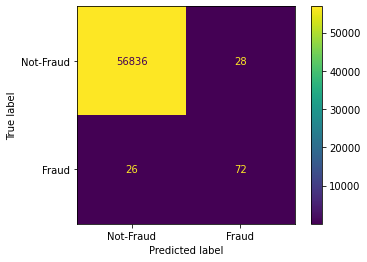

In [39]:
plot_confusion_matrix(dt, X_test, y_test, display_labels=['Not-Fraud', 'Fraud'])

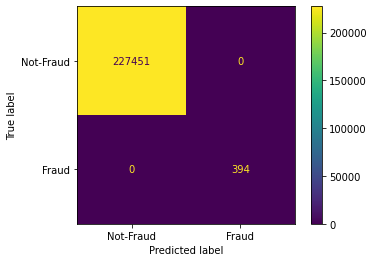

In [40]:
plot_confusion_matrix(dt, X_train, y_train, display_labels=['Not-Fraud', 'Fraud'])

In [41]:
y_pred = dt.predict(X_test)

In [42]:
print(classification_report(y_test, y_pred))
print("F1 score:: ", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.73      0.73        98

    accuracy                           1.00     56962
   macro avg       0.86      0.87      0.86     56962
weighted avg       1.00      1.00      1.00     56962

F1 score::  0.7272727272727272


### We obtain a F1 score of 0.72 to 0.75
### We can try to fine-tune by pruning the tree and see if it improves the model metrics

In [17]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts= []
for ccp_alpha in ccp_alphas:
    dtc = tree.DecisionTreeClassifier(random_state= 0, ccp_alpha=ccp_alpha)
    dtc.fit(X_train, y_train)
    clf_dts.append(dtc)

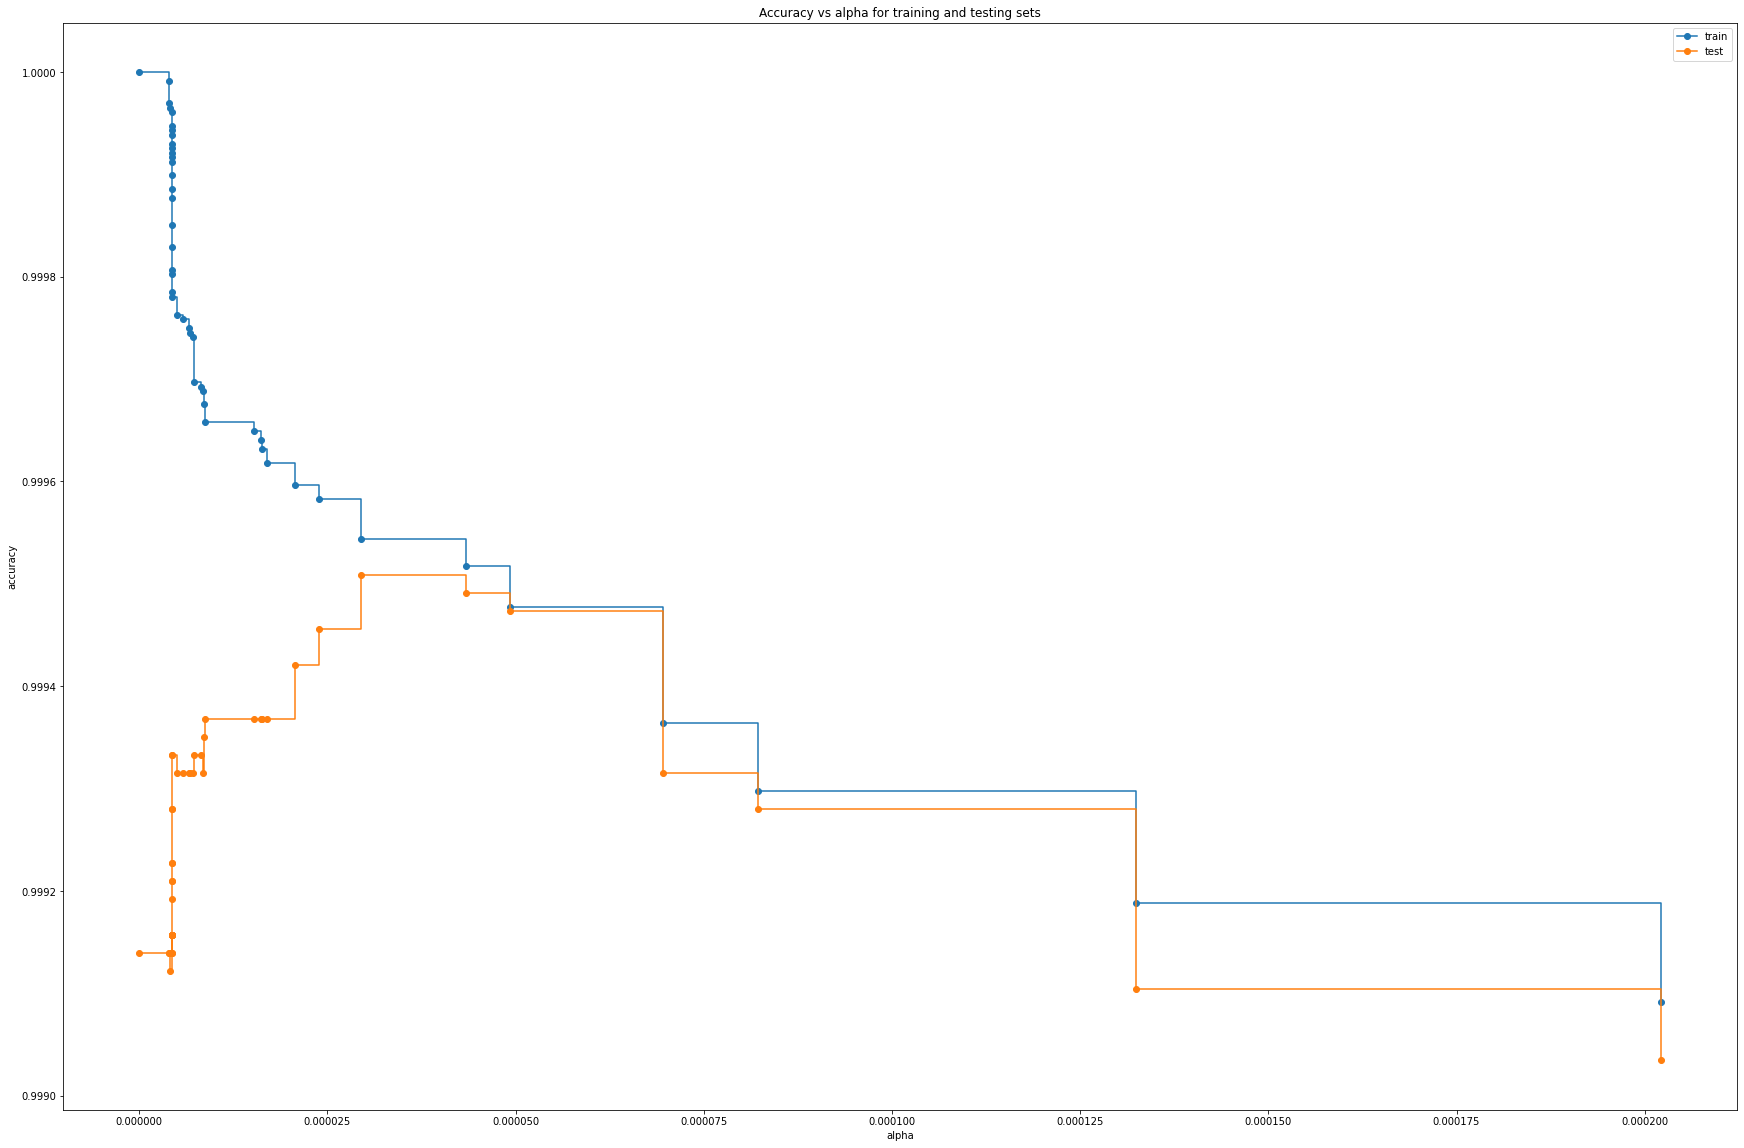

In [30]:
train_scores = [x.score(X_train, y_train) for x in clf_dts]
test_scores = [x.score(X_test, y_test) for x in clf_dts]

fig, ax = plt.subplots(figsize=(30, 20))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [20]:
path = dtc.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]


In [21]:
print(len(ccp_alphas))

45


In [23]:
def find_scores(ccp_alpha):
    dtc = tree.DecisionTreeClassifier(random_state= 0, ccp_alpha=ccp_alpha)
    score = cross_val_score(dtc, X_train, y_train, scoring="f1", cv=5)
    return [ccp_alpha, np.mean(score)]

In [24]:
alpha_scores= []
# for ccp_alpha in ccp_alphas:
#     p = multiprocessing.Process(target=find_scores, args=(ccp_alpha,))
#     alpha_scores.append(p)
#     p.start()
    
pool = multiprocessing.Pool(processes=5)
alpha_scores = pool.map(find_scores, ccp_alphas)
pool.close()

<AxesSubplot:xlabel='alpha'>

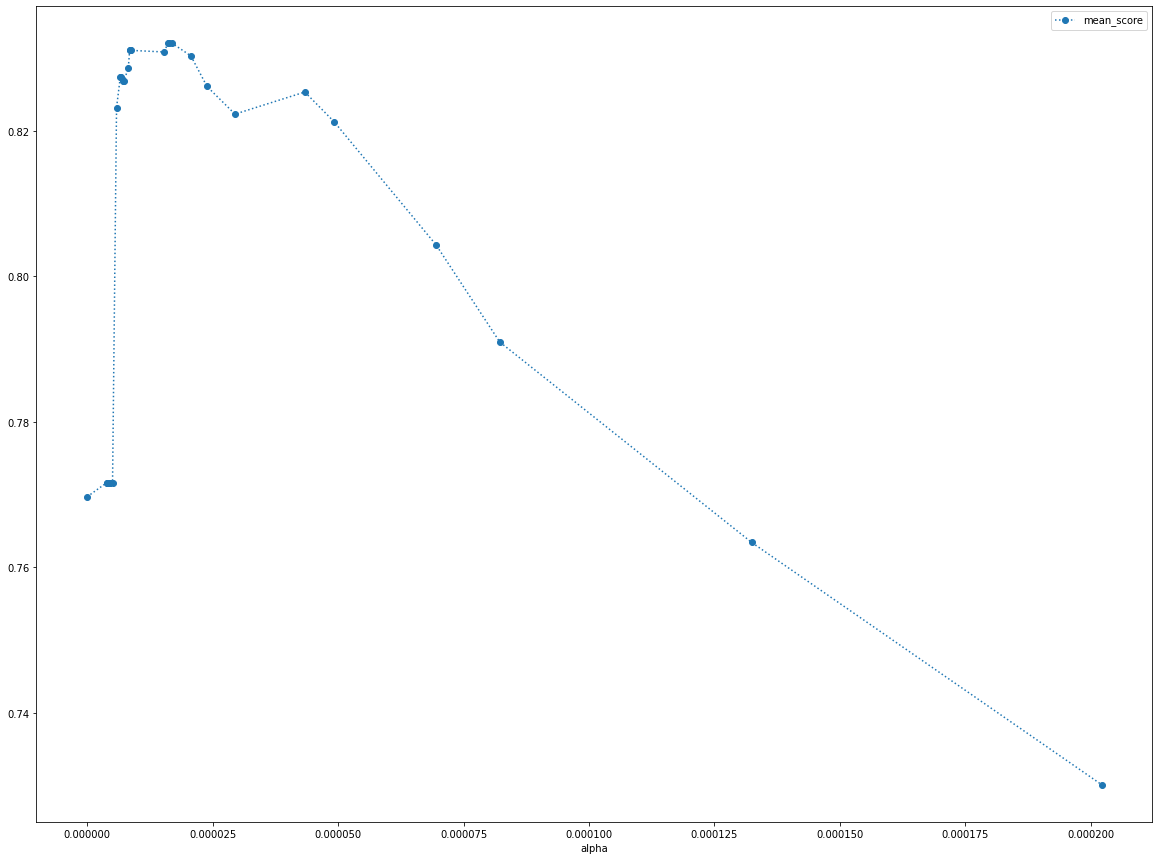

In [29]:
alpha_df = pd.DataFrame(alpha_scores, columns = ['alpha', 'mean_score'])

alpha_df.plot(x='alpha', y='mean_score', marker='o', linestyle=":", figsize=(20, 15))

In [31]:
alpha_df[(alpha_df['alpha']>0.00002) & (alpha_df['alpha']<0.00003)]

,alpha,mean_score
36,0.000021,0.830303
37,0.000024,0.826103
38,0.000029,0.822296


In [43]:
dtc_pruned = tree.DecisionTreeClassifier(random_state=0, ccp_alpha = 0.000021)
dtc_pruned.fit(X_train, y_train)
y_pred = dtc_pruned.predict(X_test)


In [44]:
print(classification_report(y_test, y_pred))
print("F1 score:: ", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.76      0.82        98

    accuracy                           1.00     56962
   macro avg       0.95      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962

F1 score::  0.8176795580110497


### The F1 score  improved to 0.82
### next we can try Random Forest Classifier and see if it improves the model metrics

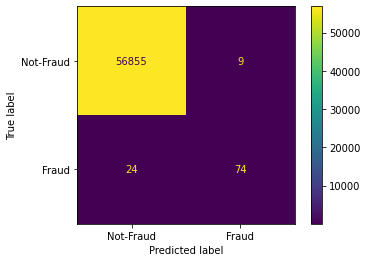

In [45]:
plot_confusion_matrix(dtc_pruned, X_test, y_test, display_labels=['Not-Fraud', 'Fraud'])

In [49]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

F1 score::  0.8587570621468926


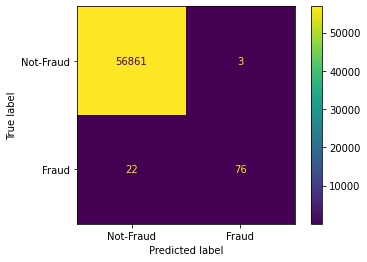

In [51]:
print(classification_report(y_test, y_pred))
print("F1 score:: ", f1_score(y_test, y_pred))
plot_confusion_matrix(rf, X_test, y_test, display_labels=['Not-Fraud', 'Fraud'])

### We achieved an improvement of the F1 score up to 0.86 <br> <br> Let's try if we can improve it any more

In [52]:
rf_pruned = RandomForestClassifier(n_estimators=1000, max_depth=10)
rf_pruned.fit(X_train, y_train)
y_pred = rf_pruned.predict(X_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

F1 score::  0.8474576271186441


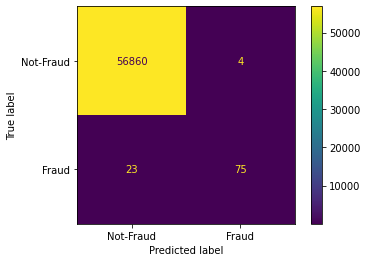

In [53]:
print(classification_report(y_test, y_pred))
print("F1 score:: ", f1_score(y_test, y_pred))
plot_confusion_matrix(rf_pruned, X_test, y_test, display_labels=['Not-Fraud', 'Fraud'])

### There is no improvement with setting the max_depth parameter. Thus we set our baseline model performance as 0.86 <br> <br> Let's see if we can improve it by applying further techniques

In [54]:
# the amount class needs to be scaled before PCA is applied to it
scaler = StandardScaler()
X = scaler.fit_transform(df.drop("Class", axis=1))

In [55]:
pca = PCA()
X_pca = pca.fit_transform(X)

In [56]:
print(pca.explained_variance_) 

[1.95826326 1.6836999  1.00000351 1.00000351 1.00000351 1.00000351
 1.00000351 1.00000351 1.00000351 1.00000351 1.00000351 1.00000351
 1.00000351 1.00000351 1.00000351 1.00000351 1.00000351 1.00000351
 1.00000351 1.00000351 1.00000351 1.00000351 1.00000351 1.00000351
 1.00000351 1.00000351 1.00000351 1.00000351 0.31589583 0.04215505]


In [57]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ["PCA_"+str(i) for i in range(1, len(per_var)+1)]

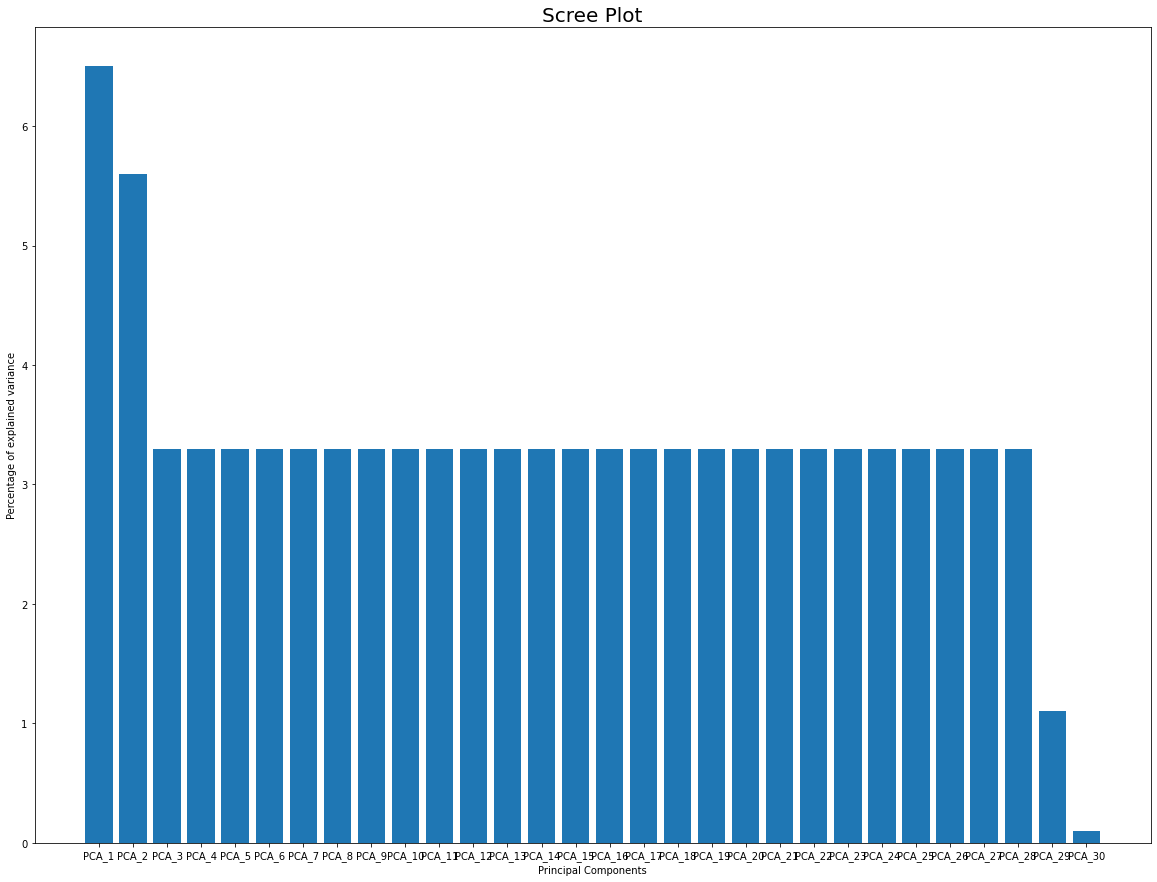

In [58]:
fig = plt.figure(figsize=(20, 15))
plt.bar(x = range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot', fontsize=20)
plt.show()

## What happens if I change the number of components to 2

In [59]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [60]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ["PCA_"+str(i) for i in range(1, len(per_var)+1)]

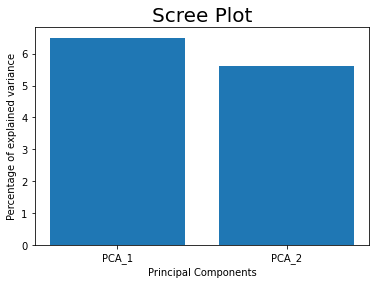

In [61]:
plt.bar(x = range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot', fontsize=20)
plt.show()

### So changing the number of components does not change the calculation of the components, it just returns the asked number of components out of the total number of calculated components

https://stats.stackexchange.com/questions/501226/if-my-explained-variance-is-low-in-my-pca-component-is-it-still-useful-for-cl

### As per https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/, we can use ANOVA for feature selection when input features are numerical and the target variable is categorical

In [62]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# generate dataset
X = df.drop("Class", axis=1)
y = df["Class"]
# define feature selection
fs = SelectKBest(score_func=f_classif, k=10)
# apply feature selection
fs.fit(X, y)
scores = fs.scores_
score_dict = {}
for i in range(len(scores)):
    score_dict[X.columns[i]] = scores[i]
    
print("Features sorted by their scores in descending order:")
print(sorted(score_dict.items(), key=lambda item: item[1], reverse=True))
print()
print("Top 10 important features:")
print(X.columns[fs.get_support()])

Features sorted by their scores in descending order:
[('V17', 33979.16859338222), ('V14', 28695.547788069274), ('V12', 20749.822361328363), ('V10', 14057.979985070306), ('V16', 11443.34942771692), ('V3', 11014.508305392937), ('V7', 10349.605407764428), ('V11', 6999.355046891709), ('V4', 5163.832114291158), ('V18', 3584.3806050744884), ('V1', 2955.6689455056726), ('V9', 2746.600273276989), ('V5', 2592.3579287739644), ('V2', 2393.401678395271), ('V6', 543.5105776024088), ('V21', 465.9162513462646), ('V19', 344.99099663763803), ('V20', 114.99973120818467), ('V8', 112.54828680795946), ('V27', 88.04529630335085), ('Time', 43.252997839269305), ('V28', 25.901404598714073), ('V24', 14.850932491653863), ('Amount', 9.033344712058762), ('V13', 5.947672351915797), ('V26', 5.653652932587404), ('V15', 5.080193490444479), ('V25', 3.116061764635058), ('V23', 2.0534763283065742), ('V22', 0.18470649625032598)]

Top 10 important features:
Index(['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17',

## There is another method that can be used for feature selection - Recursive Feature Elimination technique. In this technique we use a machine learning algorithm that can return some scores - generally Decision Tree is used for this. We also define the required number of features.

### But my concern is that if the data is imbalanced to this level, it might be difficult for the Decision Tree to work properly and hence the true essence of this algorithm can't be explored. So first, we should do something regarding the imbalance in the data.

Right now our dataset has a 1:500 (0.002) class distribution

In [63]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.1)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X, y = under.fit_resample(X, y)

In [64]:
classes, counts = np.unique(y, return_counts=True)

# identify the data percentage
for i in range(len(classes)):
    print("Class=%d, Count=%d, Percentage=%.3f%%" % (classes[i], counts[i], counts[i]*100/np.sum(counts)))
print("Class Imbalance:: {}".format(np.round(np.min(counts)/np.max(counts), 3)))

Class=0, Count=56862, Percentage=66.667%
Class=1, Count=28431, Percentage=33.333%
Class Imbalance:: 0.5


### Possible concerns: <br> <br> (i) The Oversampling creates duplicates of the data points in the minority class. This can result is strong overfitting problem. <br> (ii) The undersampling randomly eliminates data points in the majority class. This can result in useful information getting lost. <br> Both of these methods can tend to reduce the performance of the model.
